In [1]:
import tensorflow as tf
import pathlib
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
from sklearn.model_selection import train_test_split
from tensorflow.keras import activations
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, SeparableConv2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation, Add

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
country_images_root = pathlib.Path("/home/pascal_steiger/Downloads/data3/")

In [4]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr

In [5]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data3/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

img_df.sample(n=10)

,path,label
1233,/home/pascal_steiger/Downloads/data3/PRT/img_P...,PRT
1001,/home/pascal_steiger/Downloads/data3/ISL/img_I...,ISL
2336,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE
2441,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE
2512,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE
2865,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE
598,/home/pascal_steiger/Downloads/data3/ISL/img_I...,ISL
960,/home/pascal_steiger/Downloads/data3/ISL/img_I...,ISL
2331,/home/pascal_steiger/Downloads/data3/CHE/img_4...,CHE
1287,/home/pascal_steiger/Downloads/data3/PRT/img_P...,PRT


In [6]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)

                                                   path label
1800  /home/pascal_steiger/Downloads/data3/PRT/img_P...   PRT
2363  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
1605  /home/pascal_steiger/Downloads/data3/PRT/img_P...   PRT
1345  /home/pascal_steiger/Downloads/data3/PRT/img_P...   PRT
2817  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
(2409, 2)
                                                   path label
2550  /home/pascal_steiger/Downloads/data3/CHE/img_4...   CHE
1620  /home/pascal_steiger/Downloads/data3/PRT/img_P...   PRT
812   /home/pascal_steiger/Downloads/data3/ISL/img_I...   ISL
790   /home/pascal_steiger/Downloads/data3/ISL/img_I...   ISL
1075  /home/pascal_steiger/Downloads/data3/PRT/img_P...   PRT
(603, 2)


In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(400, 400),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(400, 400),
        batch_size=32,
        class_mode="sparse",
        seed=42
)

Found 2409 validated image filenames belonging to 3 classes.
Found 603 validated image filenames belonging to 3 classes.


In [10]:
with tf.device("/device:GPU:1"):   
    I = Input(shape=(400,400,3), dtype="float32")

    c2d1= Conv2D(32, (3, 3), (2, 2), activation="relu")(I)
    b1 = BatchNormalization()(c2d1)
    c2d2= Conv2D(64, (3, 3), activation="relu")(b1)
    b2 = BatchNormalization()(c2d2)

    c1d1= Conv2D(1, 1, (2, 2))(b2)
    b3 = BatchNormalization()(c1d1)

    sc2d1= SeparableConv2D(128, (3, 3), padding="same")(b2)
    b4 = BatchNormalization()(sc2d1)
    relu1= Activation(activations.relu)(b4)
    sc2d2= SeparableConv2D(128, (3, 3), padding="same")(relu1)
    b5 = BatchNormalization()(sc2d2)
    mp1= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b5)

    add1 = Add()([b3, mp1])

    c1d2= Conv2D(1, 1, (2, 2))(add1)
    b6 = BatchNormalization()(c1d2)

    relu2= Activation(activations.relu)(add1)
    sc2d3= SeparableConv2D(256, (3, 3), padding="same")(relu2)
    b7 = BatchNormalization()(sc2d3)
    relu3= Activation(activations.relu)(b7)
    sc2d4= SeparableConv2D(256, (3, 3), padding="same")(relu3)
    b8 = BatchNormalization()(sc2d4)
    mp2= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b8)

    add2 = Add()([b6, mp2])

    c1d3= Conv2D(1, 1, (2, 2))(add2)
    b9 = BatchNormalization()(c1d3)

    relu4= Activation(activations.relu)(add2)
    sc2d5= SeparableConv2D(728, (3, 3), padding="same")(relu4)
    b10 = BatchNormalization()(sc2d5)
    relu5= Activation(activations.relu)(b10)
    sc2d6= SeparableConv2D(728, (3, 3), padding="same")(relu5)
    b11 = BatchNormalization()(sc2d6)
    mp3= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b11)

    add3 = Add()([b9, mp3])

    relu6= Activation(activations.relu)(add3)
    sc2d7= SeparableConv2D(728, (3, 3), padding="same")(relu6)
    b12 = BatchNormalization()(sc2d7)
    relu7= Activation(activations.relu)(b12)
    sc2d8= SeparableConv2D(728, (3, 3), padding="same")(relu7)
    b13 = BatchNormalization()(sc2d8)

    add4 = Add()([add3, b13])

    relu8= Activation(activations.relu)(add4)
    sc2d9= SeparableConv2D(728, (3, 3), padding="same")(relu8)
    b14 = BatchNormalization()(sc2d9)
    relu9= Activation(activations.relu)(b14)
    sc2d10= SeparableConv2D(728, (3, 3), padding="same")(relu9)
    b15 = BatchNormalization()(sc2d10)

    add5 = Add()([add4, b15])

    relu10= Activation(activations.relu)(add5)
    sc2d11= SeparableConv2D(728, (3, 3), padding="same")(relu10)
    b16 = BatchNormalization()(sc2d11)
    relu11= Activation(activations.relu)(b16)
    sc2d12= SeparableConv2D(728, (3, 3), padding="same")(relu11)
    b17 = BatchNormalization()(sc2d12)

    add6 = Add()([add5, b17])

    relu12= Activation(activations.relu)(add6)
    sc2d13= SeparableConv2D(728, (3, 3), padding="same")(relu12)
    b18 = BatchNormalization()(sc2d13)
    relu13= Activation(activations.relu)(b18)
    sc2d14= SeparableConv2D(728, (3, 3), padding="same")(relu13)
    b19 = BatchNormalization()(sc2d14)

    add7 = Add()([add6, b19])

    relu14= Activation(activations.relu)(add7)
    sc2d15= SeparableConv2D(728, (3, 3), padding="same")(relu14)
    b20 = BatchNormalization()(sc2d15)
    relu15= Activation(activations.relu)(b20)
    sc2d16= SeparableConv2D(728, (3, 3), padding="same")(relu15)
    b21 = BatchNormalization()(sc2d16)

    add8 = Add()([add7, b21])

    c1d4= Conv2D(1, 1, (2, 2))(add8)
    b21 = BatchNormalization()(c1d4)

    relu16= Activation(activations.relu)(add8)
    sc2d17= SeparableConv2D(728, (3, 3), padding="same")(relu16)
    b22 = BatchNormalization()(sc2d17)
    relu17= Activation(activations.relu)(b22)
    sc2d18= SeparableConv2D(1024, (3, 3), padding="same")(relu17)
    b23 = BatchNormalization()(sc2d18)
    mp9= MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(b23)

    add9 = Add()([b21, mp9])

    sc2d19= SeparableConv2D(1536, (3, 3), activation="relu")(add9)
    b24 = BatchNormalization()(sc2d19)
    sc2d20= SeparableConv2D(2048, (3, 3), activation="relu")(b24)
    b25 = BatchNormalization()(sc2d20)

    gap = GlobalAveragePooling2D()(b25)

    flat = Flatten()(gap)
    dense = Dense(1024, activation='relu')(flat)
    dropout = Dropout(0.3)(dense)
    dense2 = Dense(512, activation='relu')(dropout)
    dropout2 = Dropout(0.1)(dense2)
    dense3 = Dense(26, activation='softmax')(dropout2)

    model = tf.keras.Model(I, dense3)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [12]:
with tf.device("/device:GPU:1"):
    model.compile(optimizer = tf.optimizers.Nadam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [13]:
with tf.device("/device:GPU:1"):
    history = model.fit(train_generator,
      #steps_per_epoch=2000 // 32,  
      epochs=100,
      verbose=1,
      validation_data = validation_generator,
      callbacks = callbacks)

Epoch 1/100
76/76 [==============================] - 171s 2s/step - loss: 1.0940 - sparse_categorical_accuracy: 0.5803 - val_loss: 2.2819 - val_sparse_categorical_accuracy: 0.3101
Epoch 2/100
76/76 [==============================] - 125s 2s/step - loss: 0.6535 - sparse_categorical_accuracy: 0.7422 - val_loss: 1.6906 - val_sparse_categorical_accuracy: 0.3648
Epoch 3/100
76/76 [==============================] - 125s 2s/step - loss: 0.5225 - sparse_categorical_accuracy: 0.7958 - val_loss: 1.2831 - val_sparse_categorical_accuracy: 0.3648
Epoch 4/100
76/76 [==============================] - 125s 2s/step - loss: 0.4765 - sparse_categorical_accuracy: 0.8082 - val_loss: 1.1676 - val_sparse_categorical_accuracy: 0.3648
Epoch 5/100
76/76 [==============================] - 124s 2s/step - loss: 0.4493 - sparse_categorical_accuracy: 0.8331 - val_loss: 1.1330 - val_sparse_categorical_accuracy: 0.3847
Epoch 6/100
76/76 [==============================] - 124s 2s/step - loss: 0.4490 - sparse_categorica

76/76 [==============================] - 124s 2s/step - loss: 0.1479 - sparse_categorical_accuracy: 0.9431 - val_loss: 0.2906 - val_sparse_categorical_accuracy: 0.9071

Epoch 00045: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 46/100
76/76 [==============================] - 124s 2s/step - loss: 0.0931 - sparse_categorical_accuracy: 0.9680 - val_loss: 0.2368 - val_sparse_categorical_accuracy: 0.9237
Epoch 47/100
76/76 [==============================] - 125s 2s/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9643 - val_loss: 0.2273 - val_sparse_categorical_accuracy: 0.9287
Epoch 48/100
76/76 [==============================] - 125s 2s/step - loss: 0.0952 - sparse_categorical_accuracy: 0.9660 - val_loss: 0.2759 - val_sparse_categorical_accuracy: 0.9104
Epoch 49/100
76/76 [==============================] - 124s 2s/step - loss: 0.0951 - sparse_categorical_accuracy: 0.9635 - val_loss: 0.2903 - val_sparse_categorical_accuracy: 0.9022
Restoring model weights fro

In [14]:
with tf.device("/device:GPU:1"):
    model.save('CNN_v5_fullNet-data3.h5')

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


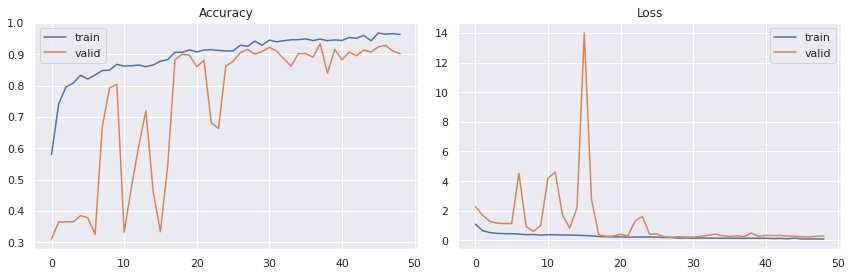

In [15]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Genaiugkeit')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(400,400)_v5-data3.png')

plt.show()

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 199, 199, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 199, 199, 32) 128         conv2d_4[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 197, 197, 64) 18496       batch_normalization_6[0][0]      
______________________________________________________________________________________________

In [ ]:
def make_prediction(path, model, size=(250,250)):
    d = {'path': [path], 'label': [os.path.dirname(path)]}
    df = pd.DataFrame(data=d)
    pred_gen = ImageDataGenerator(rescale=1./255)
    pred_generator = pred_gen.flow_from_dataframe(
        dataframe=df,
        x_col="path",
        y_col="label",
        target_size=size,
        batch_size=1,
        shuffle=False,
        class_mode="sparse",
        seed=42
    )
    res = model.predict(pred_generator)
    return (labelStringArr[np.argmax(res)], res[0][np.argmax(res)])
    

In [ ]:
make_prediction("/mnt/data/data/POL/img_POL_50.114902597259785,21.71049290647834_180.jpg", model)

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,4))
sns.countplot(x='label', data=train_df)

In [ ]:
print("on valid data")
pred1=model.evaluate(X_valid,Y_valid)
print("accuaracy", str(pred1[1]*100))
print("Total loss",str(pred1[0]*100))
